# Forecast to Power Tutorial

This tutorial will walk through the process of going from Unidata forecast model data to AC power using the SAPM.

Table of contents:
1. [Setup](#Setup)
2. [Load Forecast data](#Load-Forecast-data)
2. [Calculate modeling intermediates](#Calculate-modeling-intermediates)
2. [DC power using SAPM](#DC-power-using-SAPM)
2. [AC power using SAPM](#AC-power-using-SAPM)

This tutorial requires pvlib >= 0.6.0.

Authors:
* Derek Groenendyk (@moonraker), University of Arizona, November 2015
* Will Holmgren (@wholmgren), University of Arizona, November 2015, January 2016, April 2016, July 2016, August 2018

## Setup

These are just your standard interactive scientific python imports that you'll get very used to using.

In [1]:
# built-in python modules
import datetime
import inspect
import os

# scientific python add-ons
import numpy as np
import pandas as pd

# plotting stuff
# first line makes the plots appear in the notebook
%matplotlib inline 
import matplotlib.pyplot as plt
import matplotlib as mpl

# finally, we import the pvlib library
from pvlib import solarposition, irradiance, atmosphere, pvsystem, inverter, temperature
from pvlib.forecast import GFS, NAM, NDFD, RAP, HRRR

c:\users\kanderso\software\anaconda3\envs\pvlib-dev\lib\site-packages\pvlib\forecast.py:19: UserWarning: The forecast module algorithms and features are highly experimental. The API may change, the functionality may be consolidated into an io module, or the module may be separated into its own package.
  'The forecast module algorithms and features are highly experimental. '


## Load Forecast data

pvlib forecast module only includes several models. To see the full list of forecast models visit the Unidata website:

http://www.unidata.ucar.edu/data/#tds

In [2]:
# Choose a location.
# Tucson, AZ
latitude = 32.2
longitude = -110.9
tz = 'US/Mountain'

Define some PV system parameters.

In [3]:
surface_tilt = 30
surface_azimuth = 180 # pvlib uses 0=North, 90=East, 180=South, 270=West convention
albedo = 0.2

In [4]:
start = pd.Timestamp(datetime.date.today(), tz=tz) # today's date
end = start + pd.Timedelta(days=7) # 7 days from today

In [5]:
# Define forecast model
fm = GFS()
#fm = NAM()
#fm = NDFD()
#fm = RAP()
#fm = HRRR()

In [6]:
# Retrieve data
forecast_data = fm.get_processed_data(latitude, longitude, start, end)

Let's look at the downloaded version of the forecast data.

In [7]:
forecast_data.head()

,temp_air,wind_speed,ghi,dni,dhi,total_clouds,low_clouds,mid_clouds,high_clouds
2020-07-07 06:00:00-06:00,29.454681,5.270410,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
2020-07-07 09:00:00-06:00,27.087494,1.988913,287.162801,140.869429,215.705993,57.0,0.0,57.0,0.0
2020-07-07 12:00:00-06:00,24.950012,3.782271,573.731739,123.802033,458.864565,59.0,0.0,59.0,0.0
2020-07-07 15:00:00-06:00,37.233734,3.298288,926.616347,767.306217,217.396559,0.0,0.0,0.0,0.0
2020-07-07 18:00:00-06:00,53.850006,3.230239,446.504106,724.204396,85.436744,0.0,0.0,0.0,0.0


This is a ``pandas DataFrame`` object. It has a lot of great properties that are beyond the scope of our tutorials.

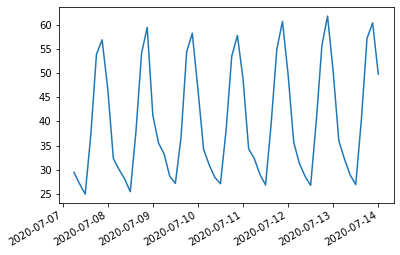

In [8]:
forecast_data['temp_air'].plot();

Plot the GHI data. Most pvlib forecast models derive this data from the weather models' cloud clover data.

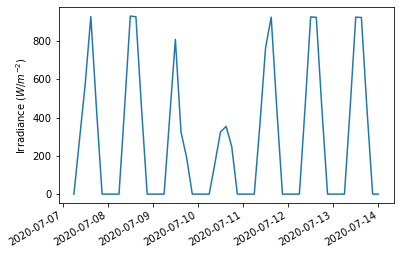

In [9]:
ghi = forecast_data['ghi']
ghi.plot()
plt.ylabel('Irradiance ($W/m^{-2}$)');

## Calculate modeling intermediates

Before we can calculate power for all the forecast times, we will need to calculate:
* solar position 
* extra terrestrial radiation
* airmass
* angle of incidence
* POA sky and ground diffuse radiation
* cell and module temperatures

The approach here follows that of the pvlib tmy_to_power notebook. You will find more details regarding this approach and the values being calculated in that notebook.

### Solar position

Calculate the solar position for all times in the forecast data. 

The default solar position algorithm is based on Reda and Andreas (2004). Our implementation is pretty fast, but you can make it even faster if you install [``numba``](http://numba.pydata.org/#installing) and use add  ``method='nrel_numba'`` to the function call below.

In [10]:
# retrieve time and location parameters
time = forecast_data.index
a_point = fm.location

In [11]:
solpos = a_point.get_solarposition(time)
#solpos.plot()

The funny looking jump in the azimuth is just due to the coarse time sampling in the TMY file.

### DNI ET

Calculate extra terrestrial radiation. This is needed for many plane of array diffuse irradiance models.

In [12]:
dni_extra = irradiance.get_extra_radiation(fm.time)

#dni_extra.plot()
#plt.ylabel('Extra terrestrial radiation ($W/m^{-2}$)')

### Airmass

Calculate airmass. Lots of model options here, see the ``atmosphere`` module tutorial for more details.

In [13]:
airmass = atmosphere.get_relative_airmass(solpos['apparent_zenith'])

#airmass.plot()
#plt.ylabel('Airmass')

The funny appearance is due to aliasing and setting invalid numbers equal to ``NaN``. Replot just a day or two and you'll see that the numbers are right.

### POA sky diffuse

Use the Hay Davies model to calculate the plane of array diffuse sky radiation. See the ``irradiance`` module tutorial for comparisons of different models.

In [14]:
poa_sky_diffuse = irradiance.haydavies(surface_tilt, surface_azimuth,
                                       forecast_data['dhi'], forecast_data['dni'], dni_extra,
                                       solpos['apparent_zenith'], solpos['azimuth'])
#poa_sky_diffuse.plot()
#plt.ylabel('Irradiance ($W/m^{-2}$)')

### POA ground diffuse

Calculate ground diffuse. We specified the albedo above. You could have also provided a string to the ``surface_type`` keyword argument.

In [15]:
poa_ground_diffuse = irradiance.get_ground_diffuse(surface_tilt, ghi, albedo=albedo)

#poa_ground_diffuse.plot()
#plt.ylabel('Irradiance ($W/m^{-2}$)')

### AOI

Calculate AOI

In [16]:
aoi = irradiance.aoi(surface_tilt, surface_azimuth, solpos['apparent_zenith'], solpos['azimuth'])

#aoi.plot()
#plt.ylabel('Angle of incidence (deg)')

Note that AOI has values greater than 90 deg. This is ok.

### POA total

Calculate POA irradiance

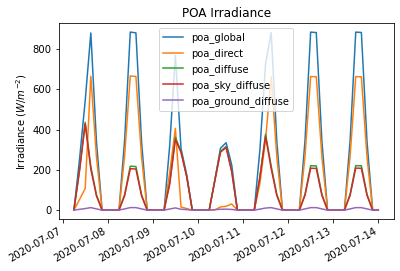

In [17]:
poa_irrad = irradiance.poa_components(aoi, forecast_data['dni'], poa_sky_diffuse, poa_ground_diffuse)

poa_irrad.plot()
plt.ylabel('Irradiance ($W/m^{-2}$)')
plt.title('POA Irradiance');

### Cell temperature

Calculate pv cell temperature

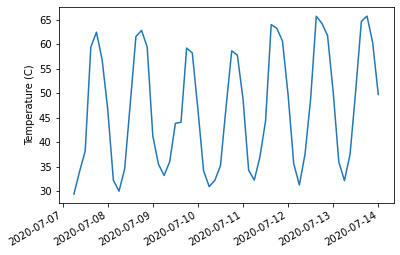

In [18]:
ambient_temperature = forecast_data['temp_air']
wnd_spd = forecast_data['wind_speed']
thermal_params = temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_polymer']
pvtemp = temperature.sapm_cell(poa_irrad['poa_global'], ambient_temperature, wnd_spd, **thermal_params)

pvtemp.plot()
plt.ylabel('Temperature (C)');

## DC power using SAPM

Get module data from the web.

In [19]:
sandia_modules = pvsystem.retrieve_sam('SandiaMod')

Choose a particular module

In [20]:
sandia_module = sandia_modules.Canadian_Solar_CS5P_220M___2009_
sandia_module

Vintage                                                          2009
Area                                                            1.701
Material                                                         c-Si
Cells_in_Series                                                    96
Parallel_Strings                                                    1
Isco                                                          5.09115
Voco                                                          59.2608
Impo                                                          4.54629
Vmpo                                                          48.3156
Aisc                                                         0.000397
Aimp                                                         0.000181
C0                                                            1.01284
C1                                                         -0.0128398
Bvoco                                                        -0.21696
Mbvoc               

Run the SAPM using the parameters we calculated above.

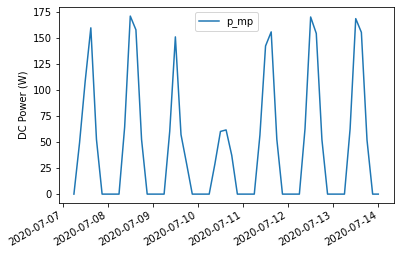

In [21]:
effective_irradiance = pvsystem.sapm_effective_irradiance(poa_irrad.poa_direct, poa_irrad.poa_diffuse, 
                                                          airmass, aoi, sandia_module)

sapm_out = pvsystem.sapm(effective_irradiance, pvtemp, sandia_module)
#print(sapm_out.head())

sapm_out[['p_mp']].plot()
plt.ylabel('DC Power (W)');

## AC power using SAPM

Get the inverter database from the web

In [22]:
sapm_inverters = pvsystem.retrieve_sam('sandiainverter')

Choose a particular inverter

In [23]:
sapm_inverter = sapm_inverters['ABB__MICRO_0_25_I_OUTD_US_208__208V_']
sapm_inverter

Vac                          208
Pso                      2.08961
Paco                         250
Pdco                     259.589
Vdco                          40
C0                      -4.1e-05
C1                      -9.1e-05
C2                      0.000494
C3                     -0.013171
Pnt                        0.075
Vdcmax                        50
Idcmax                   6.48972
Mppt_low                      30
Mppt_high                     50
CEC_Date                     NaN
CEC_Type     Utility Interactive
Name: ABB__MICRO_0_25_I_OUTD_US_208__208V_, dtype: object

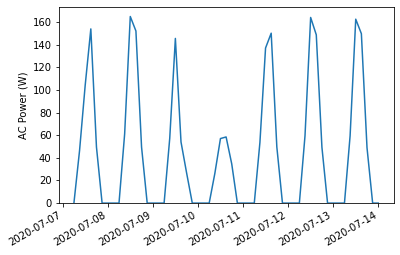

In [24]:
p_ac = inverter.sandia(sapm_out.v_mp, sapm_out.p_mp, sapm_inverter)

p_ac.plot()
plt.ylabel('AC Power (W)')
plt.ylim(0, None);

Plot just a few days.

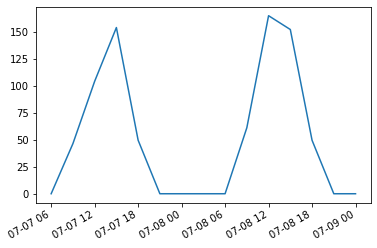

In [25]:
p_ac[start:start+pd.Timedelta(days=2)].plot();

Some statistics on the AC power

In [26]:
p_ac.describe()

count     55.000000
mean      44.950796
std       57.381541
min       -0.075000
25%       -0.075000
50%       26.079967
75%       58.926306
max      164.985484
dtype: float64

In [27]:
p_ac.index.freq

In [28]:
# integrate power to find energy yield over the forecast period
p_ac.sum() * 3

7416.881315701111